<a href="https://colab.research.google.com/github/Choudhry18/Assignment-1/blob/main/Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytrends

In [2]:
from pytrends.request import TrendReq
from pylab import rcParams
from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns

plt.rcParams.update({'font.size': 9})

sns.set(style="darkgrid")

pytrend = TrendReq()

In [4]:
test_samples = {'sample': ["Gaza", "Ukraine", "Russia", "Israel"]}

def get_google_trends_data(list_product, time_start, time_end, state=None, country='US'):
    if state:
        sigla='{}-{}'.format(country, state)
    else:
        sigla='{}'.format(country)

    data_composer = '{} {}'.format(time_start, time_end)
    pytrend.build_payload(kw_list=list_product,
                                  geo=sigla,
                                  cat=0,
                                  timeframe=data_composer)

    return pytrend.interest_over_time()

list_product= test_samples['sample']

In [5]:
dataset = get_google_trends_data(list_product=list_product, time_start='2014-01-01', time_end='2024-05-01')

In [6]:
def export_data_csv(dataset, save_output):
    dataset.to_csv(save_output, sep=",")

In [8]:
del dataset['isPartial']
dataset.style.background_gradient(cmap='Greens')

,Gaza,Ukraine,Russia,Israel
date,,,,
2014-01-01 00:00:00,0,2,4,4
2014-02-01 00:00:00,0,6,13,4
2014-03-01 00:00:00,0,14,12,4
2014-04-01 00:00:00,0,5,5,4
2014-05-01 00:00:00,0,5,5,5
2014-06-01 00:00:00,0,2,5,4
2014-07-01 00:00:00,7,5,5,15
2014-08-01 00:00:00,3,4,4,9
2014-09-01 00:00:00,0,3,4,5


In [9]:
describe = dataset.describe()
describe.style.background_gradient(cmap='Greens')

,Gaza,Ukraine,Russia,Israel
count,125.000000,125.000000,125.000000,125.000000
mean,0.440000,4.584000,6.016000,5.544000
std,1.919341,11.735790,7.336370,6.047532
min,0.000000,1.000000,3.000000,3.000000
25%,0.000000,1.000000,4.000000,4.000000
50%,0.000000,1.000000,4.000000,4.000000
75%,0.000000,5.000000,6.000000,5.000000
max,18.000000,100.000000,72.000000,65.000000


In [10]:
def show_point_compare(df):
    plt.figure(figsize=(15, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], '--')

    plt.title("Search")
    plt.legend(df.columns)
    plt.xlabel("data")
    plt.ylabel("frequency")
    plt.grid("b--")
    plt.show()

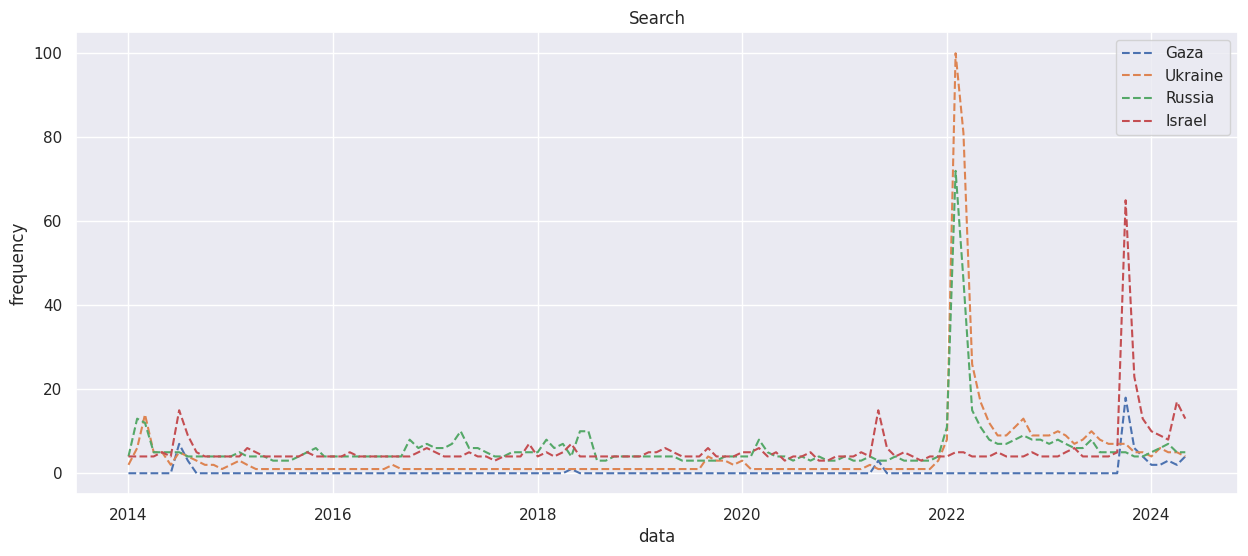

In [11]:
show_point_compare(dataset)

In [12]:
def show_line_compare(df):
    plt.figure(figsize=(15, 6))
    for col in df.columns:
        plt.plot(df.index, df[col])

    plt.title("Search")
    plt.legend(df.columns)
    plt.xlabel("data")
    plt.ylabel("frequency")
    plt.grid()
    plt.show()

def get_media_year(ano):
    y_index = dataset[ano]
    show_line_compare(y_index)

In [14]:
def frequency_total(ano=None):
    plt.figure(figsize=(15, 6))
    if ano:
        title=f"Product by search-{ano}"
        yi = dataset[ano]
        produtos_sum = yi.sum()
        plt.pie(produtos_sum, labels=list_product,
                 autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                shadow=True)
        centre_circle = plt.Circle((0,0),0.65,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.axis('equal')
        plt.tight_layout()

    else:
        explode = (0, 0.1, 0)
        produtos_sum = dataset.sum()
        title=f"Product by search"
        plt.pie(produtos_sum, labels=list_product,
        autopct='%1.1f%%', startangle=90, pctdistance=0.85)
        centre_circle = plt.Circle((0,0),0.65,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.axis('equal')
        plt.tight_layout()

    plt.axis('equal')
    plt.title(title)
    plt.show()

In [15]:
dataset.head()

,Gaza,Ukraine,Russia,Israel
date,,,,
2014-01-01,0,2,4,4
2014-02-01,0,6,13,4
2014-03-01,0,14,12,4
2014-04-01,0,5,5,4
2014-05-01,0,5,5,5


In [13]:
export_data_csv(dataset, "save_output")

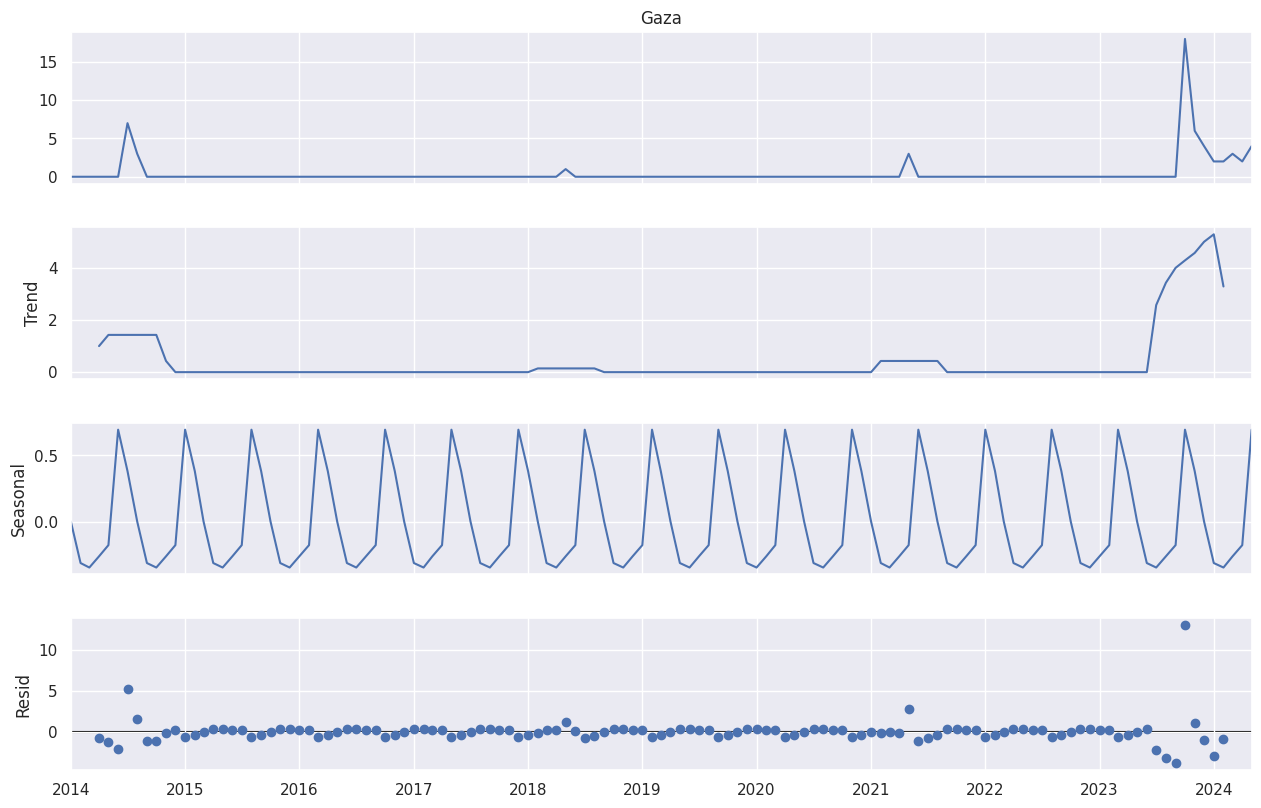

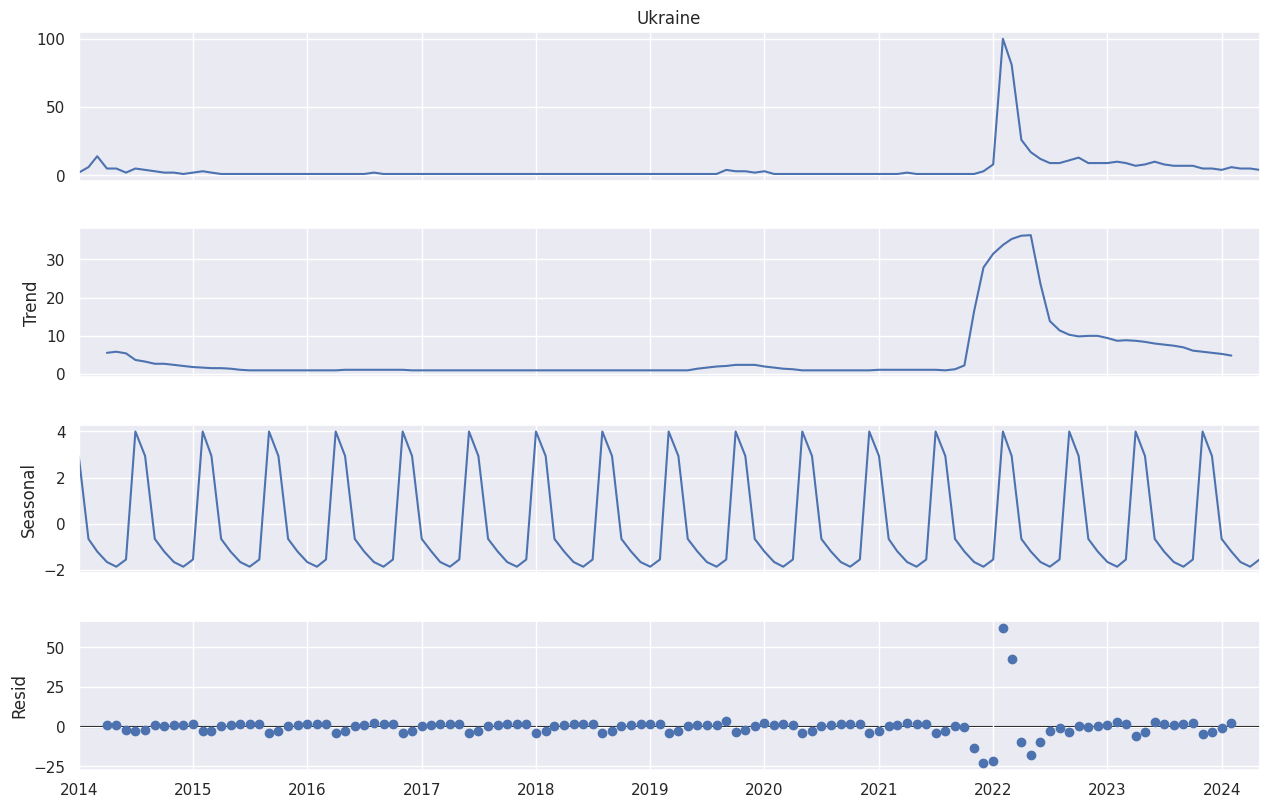

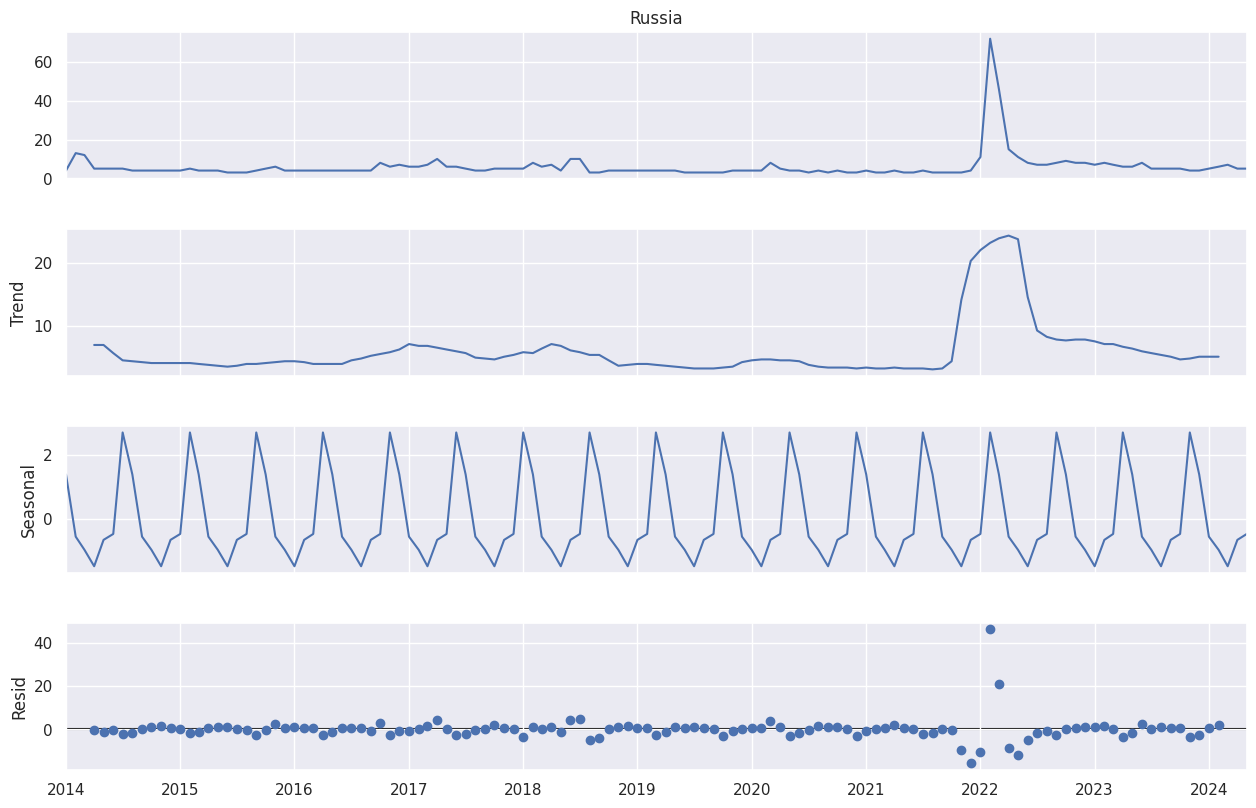

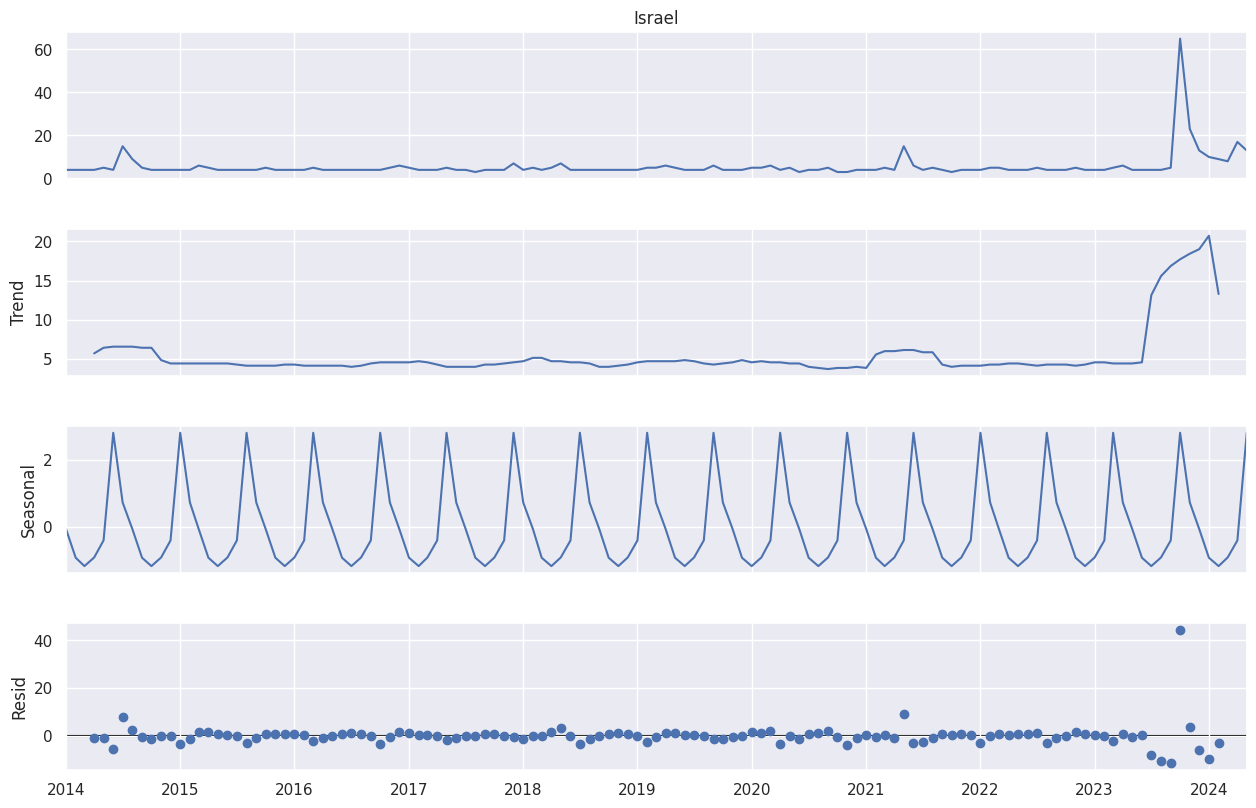

In [16]:
for col in dataset.columns:
    frequencia = 7
    result = sm.tsa.seasonal_decompose(dataset[col].dropna(),
                                        period=frequencia)
    fig = result.plot()
    fig.set_figheight(9)
    fig.set_figwidth(14)
    plt.show()

Training SARIMAX model ... product: Gaza
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1982      0.706      0.281      0.779      -1.185       1.581
ma.L1         -0.8712      0.157     -5.547      0.000      -1.179      -0.563
ar.S.L12      -0.1173      0.356     -0.330      0.742      -0.815       0.580
sigma2         3.5554      0.082     43.447      0.000       3.395       3.716
Training SARIMAX model ... product: Ukraine
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6419      0.071      8.982      0.000       0.502       0.782
ma.L1         -1.0000    132.144     -0.008      0.994    -259.998     257.998
ar.S.L12      -0.4852      0.027    -17.761      0.000      -0.539      -0.432
sigma2       148.9296   1.97e+04      0.008   

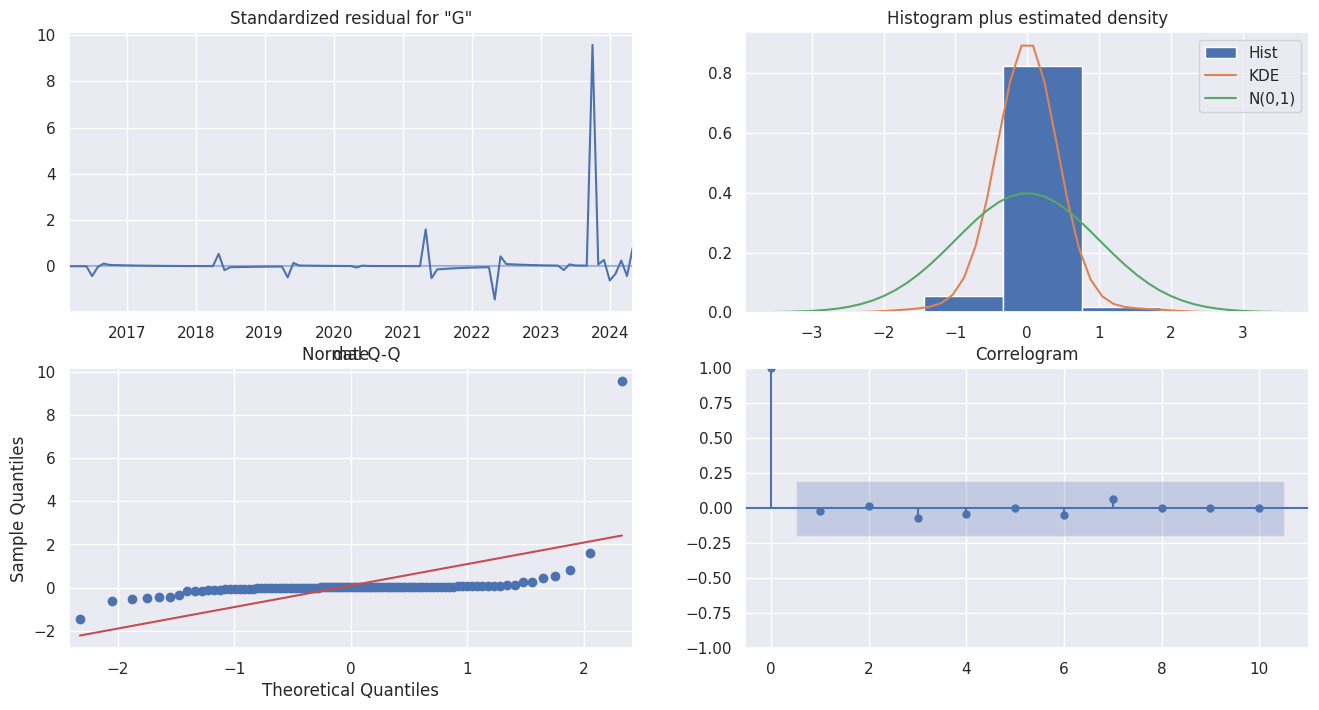

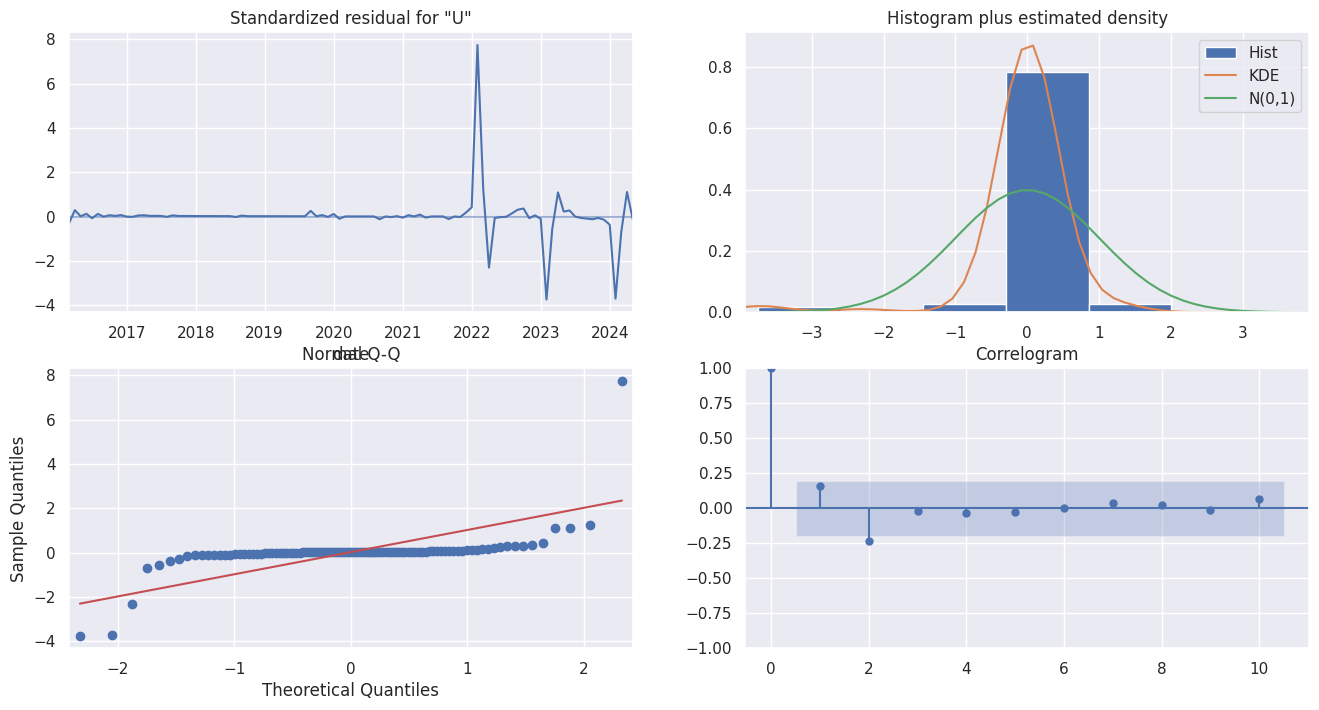

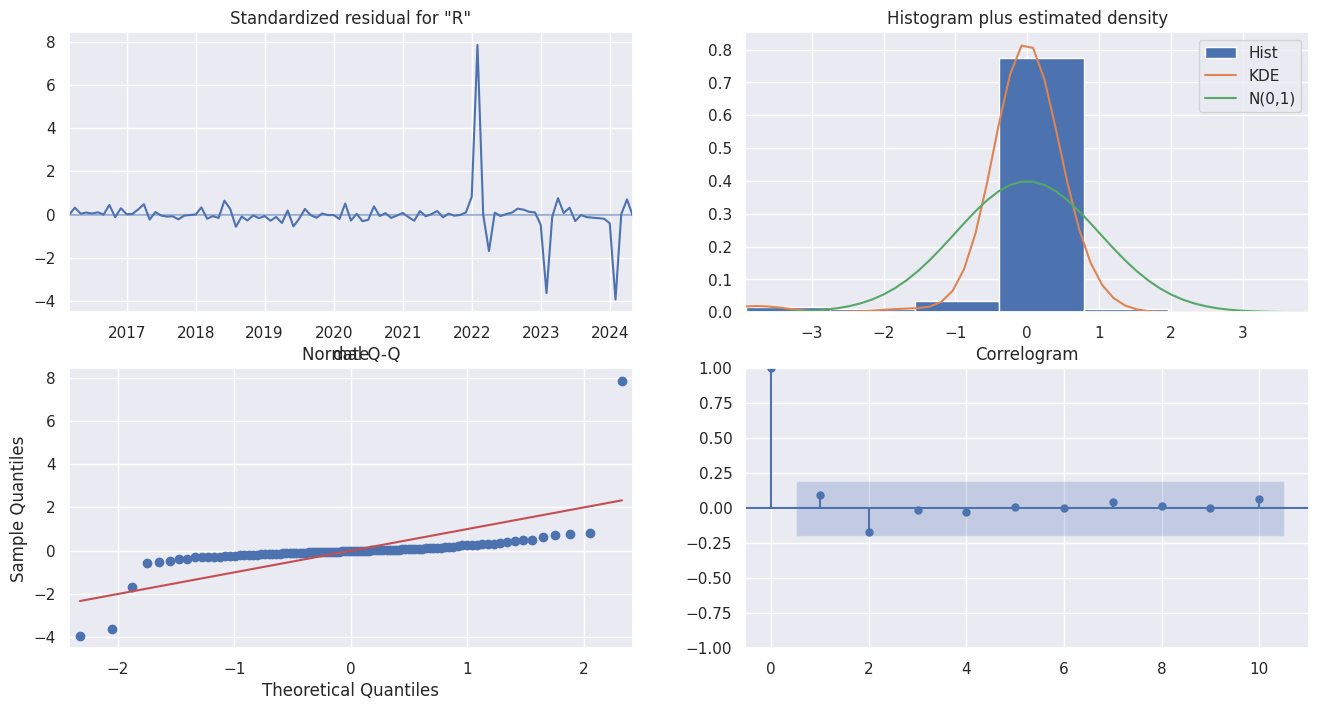

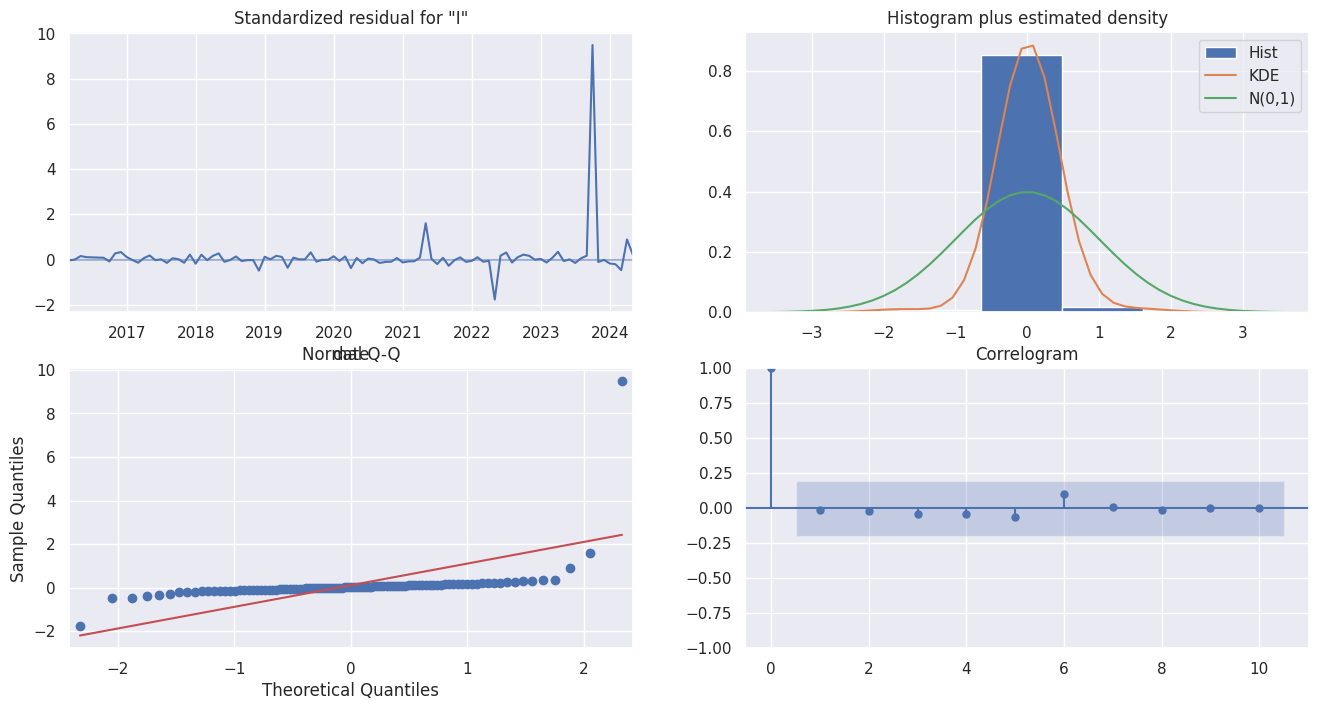

In [17]:
y = dataset.resample('MS').mean()
parametros = {
                "order": (1, 1, 1),
                "seas_order": (1, 1, 0, 12)
             }

predict_model = []
for col in y.columns:
    print(f"Training SARIMAX model ... product: {col}")
    modelo = sm.tsa.statespace.SARIMAX(y[col],
                                order=parametros["order"],
                                seasonal_order=parametros["seas_order"],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = modelo.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(16, 8))
    predict_model.append(results)